# SOFA-Score Berechnung: Vereinfachte Version

Dieses Notebook demonstriert die Berechnung des SOFA-Scores (Sequential Organ Failure Assessment) mit verschiedenen Aggregations- und Imputationsmethoden. Es ist für Anästhesisten konzipiert, um das Medaillon-Prinzip in der klinischen Datenverarbeitung zu verstehen.

## 1. Einrichtung und Import der erforderlichen Bibliotheken

In [23]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Pfad zum Projektverzeichnis hinzufügen, um Module zu importieren
sys.path.append('..')

# Import der eigenen Module
from src.database import DatabaseConnection
from src.pipeline import DataPipeline

# Matplotlib-Einstellungen für bessere Visualisierung
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12

## 2. Verbindung zur Datenbank herstellen

In [24]:
# Datenbankverbindung herstellen
db = DatabaseConnection()
print("Verbindung zur Datenbank hergestellt.")

# Verfügbare Schemas anzeigen
schemas = db.get_schema_names()
print("Verfügbare Schemas:")
for schema in schemas:
    print(f"- {schema}")

Verbindung zur Datenbank hergestellt.
Verfügbare Schemas:
- public
- mimiciv_hosp
- mimiciv_icu
- mimiciv_derived
- bronze_schema
- silver_schema
- gold_schema


## 3. Überprüfung der Silver-Tabelle

In [25]:
# Silver-Schema und Tabelle definieren
silver_schema = "silver_schema"
standardized_table = "standardized_parameters"

# Tabellen im Silver-Schema anzeigen
silver_tables = db.get_tables(silver_schema)
print(f"Tabellen im Schema '{silver_schema}':")
for table in silver_tables:
    print(f"- {table}")

# Stichprobe der Daten laden
query = f"""
SELECT * 
FROM {silver_schema}.{standardized_table}
WHERE is_outlier = FALSE
LIMIT 10
"""
sample_data = db.execute_query(query)
print("\nStichprobe der Silver-Daten:")
display(sample_data)

Tabellen im Schema 'silver_schema':
- standardized_parameters
- parameter_mapping
- physiological_limits

Stichprobe der Silver-Daten:


,id,subject_id,hadm_id,stay_id,charttime,concept_id,concept_name,value,unit,is_error,is_outlier,source_itemid,source_table
0,1,10005817,20626031,32604416,2132-12-16 00:00:00,4313591,Respiratory rate,19.0,insp/min,False,False,220210,chartevents
1,2,10005817,20626031,32604416,2132-12-16 00:00:00,45771331,Temperature,37.0,°C,False,False,223762,chartevents
2,3,10005817,20626031,32604416,2132-12-16 00:00:00,3008223,Glasgow Coma Scale motor response,6.0,None,False,False,223901,chartevents
3,4,10005817,20626031,32604416,2132-12-16 00:00:00,3007194,Glasgow Coma Scale total,3.0,None,False,False,220739,chartevents
4,5,10005817,20626031,32604416,2132-12-16 00:00:00,3009094,Glasgow Coma Scale verbal response,5.0,None,False,False,223900,chartevents
5,6,10005817,20626031,32604416,2132-12-16 00:00:00,4020553,Oxygen saturation measurement,95.0,%,False,False,220277,chartevents
6,7,10005817,20626031,32604416,2132-12-16 00:00:00,3004249,Systolic blood pressure,117.0,mmHg,False,False,220050,chartevents
7,8,10005817,20626031,32604416,2132-12-16 01:00:00,45771331,Temperature,37.0,°C,False,False,223762,chartevents
8,9,10005817,20626031,32604416,2132-12-16 01:00:00,4020553,Oxygen saturation measurement,96.0,%,False,False,220277,chartevents
9,11,10005817,20626031,32604416,2132-12-16 01:00:00,3004249,Systolic blood pressure,125.0,mmHg,False,False,220050,chartevents


## 4. Daten aus der Silver-Tabelle laden

In [26]:
# Alle relevanten Daten für den SOFA-Score laden
query = f"""
SELECT * 
FROM {silver_schema}.{standardized_table}
WHERE is_outlier = FALSE
AND concept_name IN (
    -- Vitalparameter
    'Respiratory rate',
    'Oxygen saturation measurement',
    'Systolic blood pressure',
    'Diastolic blood pressure',
    'Mean arterial pressure',
    'Temperature',
    
    -- SOFA: GCS Parameter
    'Glasgow Coma Scale total',
    'Glasgow Coma Scale verbal response',
    'Glasgow Coma Scale motor response',
    'Glasgow Coma Scale eye opening',
    
    -- SOFA: Beatmungsparameter
    'Ventilator mode',
    'Ventilation status',
    
    -- Laborwerte
    'Platelets',
    'Bilirubin.total',
    'Creatinine',
    'Sodium',
    'Oxygen [Partial pressure] in Arterial blood',
    
    -- Beatmungsparameter
    'Oxygen/Gas total [Pure volume fraction] Inhaled gas',
    
    -- Ausscheidungen
    'Urine output'
)
"""
silver_data = db.execute_query(query)
print(f"Anzahl der geladenen Zeilen: {len(silver_data)}")
print(f"Anzahl der Spalten: {len(silver_data.columns)}")

# Überprüfen der eindeutigen Konzepte
unique_concepts = silver_data['concept_name'].unique()
print(f"\nAnzahl eindeutiger Konzepte: {len(unique_concepts)}")
print("Eindeutige Konzepte:")
for concept in unique_concepts:
    print(f"- {concept}")

# Gruppierung der Konzepte nach klinischer Kategorie
concept_categories = {
    "Vitalparameter": [
        "Respiratory rate", "Oxygen saturation measurement", 
        "Systolic blood pressure", "Diastolic blood pressure", 
        "Mean arterial pressure", "Temperature"
    ],
    "Neurologische Parameter": [
        "Glasgow Coma Scale total", "Glasgow Coma Scale verbal response",
        "Glasgow Coma Scale motor response", "Glasgow Coma Scale eye opening"
    ],
    "Beatmungsparameter": [
        "Ventilator mode", "Ventilation status",
        "Oxygen/Gas total [Pure volume fraction] Inhaled gas"
    ],
    "Laborwerte": [
        "Platelets", "Bilirubin.total", "Creatinine", "Sodium",
        "Oxygen [Partial pressure] in Arterial blood"
    ],
    "Ausscheidungen": [
        "Urine output"
    ]
}

print("\nKonzepte nach klinischer Kategorie:")
for category, concepts in concept_categories.items():
    print(f"\n{category}:")
    for concept in concepts:
        if concept in unique_concepts:
            print(f"  ✓ {concept}")
        else:
            print(f"  ✗ {concept} (nicht in Daten vorhanden)")

Anzahl der geladenen Zeilen: 71806
Anzahl der Spalten: 13

Anzahl eindeutiger Konzepte: 16
Eindeutige Konzepte:
- Respiratory rate
- Temperature
- Glasgow Coma Scale motor response
- Glasgow Coma Scale total
- Glasgow Coma Scale verbal response
- Oxygen saturation measurement
- Systolic blood pressure
- Diastolic blood pressure
- Ventilator mode
- Ventilation status
- Sodium
- Creatinine
- Bilirubin.total
- Platelets
- Oxygen [Partial pressure] in Arterial blood
- Mean arterial pressure

Konzepte nach klinischer Kategorie:

Vitalparameter:
  ✓ Respiratory rate
  ✓ Oxygen saturation measurement
  ✓ Systolic blood pressure
  ✓ Diastolic blood pressure
  ✓ Mean arterial pressure
  ✓ Temperature

Neurologische Parameter:
  ✓ Glasgow Coma Scale total
  ✓ Glasgow Coma Scale verbal response
  ✓ Glasgow Coma Scale motor response
  ✗ Glasgow Coma Scale eye opening (nicht in Daten vorhanden)

Beatmungsparameter:
  ✓ Ventilator mode
  ✓ Ventilation status
  ✗ Oxygen/Gas total [Pure volume fractio

## 5. SOFA-Score mit Forward-Fill-Imputation (Methode 1)

In [27]:
# Konfigurationspfad für die erste Methode
config_path_1 = os.path.join('..', 'config', 'gold', 'sofa_24h_forwardfill.yaml')

# Pipeline mit der ersten Konfiguration erstellen
pipeline_1 = DataPipeline(config_path=config_path_1, db_connection=db)

# Pipeline ausführen
print("\nFühre Pipeline mit Forward-Fill-Imputation aus...")
gold_data_1 = pipeline_1.run_pipeline(data=silver_data, save_to_db=False)
print(f"Gold-Tabelle erstellt: {len(gold_data_1)} Zeilen, {len(gold_data_1.columns)} Spalten")

# Ergebnisse anzeigen
print("\nErste Zeilen der Gold-Tabelle (Methode 1):")
display(gold_data_1.head())

# Debugging: Verfügbare Spalten anzeigen
print("\nVerfügbare Spalten in gold_data_1:")
for col in gold_data_1.columns:
    print(f"- {col}")


Führe Pipeline mit Forward-Fill-Imputation aus...
Warnung: Erforderliche concept_id 3027801 für PaO2_FiO2_ratio nicht gefunden
Warnung: Erforderliche concept_id 42869590 für PaO2_FiO2_ratio nicht gefunden
Überspringe Berechnung von PaO2_FiO2_ratio wegen fehlender Spalten
Berechne MAP mit Formel: (result["Systolic blood pressure"] + 2 * result["Diastolic blood pressure"]) / 3
Ergebnis für MAP: Min=41.0, Max=130.38636363636363, Mittelwert=80.88669484288916
Warnung: Parameter PaO2_FiO2_ratio nicht in Daten gefunden oder Thresholds/Scores ungültig
Warnung: Parameter Platelets nicht in Daten gefunden oder Thresholds/Scores ungültig
Warnung: Parameter Bilirubin.total nicht in Daten gefunden oder Thresholds/Scores ungültig
Warnung: Parameter Mean arterial pressure nicht in Daten gefunden oder Thresholds/Scores ungültig
Berechne SOFA-Komponente cns mit Parameter Glasgow Coma Scale total
Werte in Glasgow Coma Scale total: Min=3.0, Max=4.0, Median=4.0
Komponente cns berechnet: Min=3, Max=4, Mit

/Users/me/Desktop/Code/Charité/dgai/dgai-mimic4-medaillon/medaillon-pipeline/nbs/../src/pipeline.py:146: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  result['time_window'] = result[time_col].dt.floor(time_window)
/Users/me/Desktop/Code/Charité/dgai/dgai-mimic4-medaillon/medaillon-pipeline/nbs/../src/pipeline.py:173: FutureWarning: The provided callable <function mean at 0x10fc8d300> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  aggregated = result.groupby(group_cols)[numeric_cols].agg(agg_func).reset_index()


concept_name,subject_id,hadm_id,stay_id,time_window,Diastolic blood pressure,Glasgow Coma Scale motor response,Glasgow Coma Scale total,Glasgow Coma Scale verbal response,Mean arterial pressure,Oxygen saturation measurement,Respiratory rate,Systolic blood pressure,Temperature,Ventilation status,Ventilator mode,MAP,SOFA_score,SOFA_score_cns
0,10000032,29079034.0,39553978.0,2180-07-23,54.100000,6.0,4.0,4.666667,NaN,96.300000,20.700000,88.900000,NaN,NaN,NaN,65.700000,3,3
1,10001217,24597018.0,37067082.0,2157-11-20,83.000000,6.0,4.0,5.000000,NaN,97.600000,22.800000,141.400000,NaN,NaN,NaN,102.466667,3,3
2,10001217,24597018.0,37067082.0,2157-11-21,80.954545,6.0,4.0,5.000000,NaN,95.727273,20.909091,135.136364,NaN,NaN,NaN,99.015152,3,3
3,10001217,27703517.0,34592300.0,2157-12-19,81.111111,6.0,4.0,5.000000,NaN,94.600000,14.800000,131.444444,NaN,NaN,NaN,97.888889,3,3
4,10001217,27703517.0,34592300.0,2157-12-20,68.571429,6.0,4.0,5.000000,NaN,93.400000,17.866667,105.857143,NaN,NaN,NaN,81.000000,3,3



Verfügbare Spalten in gold_data_1:
- subject_id
- hadm_id
- stay_id
- time_window
- Diastolic blood pressure
- Glasgow Coma Scale motor response
- Glasgow Coma Scale total
- Glasgow Coma Scale verbal response
- Mean arterial pressure
- Oxygen saturation measurement
- Respiratory rate
- Systolic blood pressure
- Temperature
- Ventilation status
- Ventilator mode
- MAP
- SOFA_score
- SOFA_score_cns


## 6. SOFA-Score mit Median-Imputation (Methode 2) und Last-Value-Imputation (Methode 3)

In [28]:
# Konfigurationspfad für die zweite Methode
config_path_2 = os.path.join('..', 'config', 'gold', 'sofa_alternative.yaml')

# Pipeline mit der zweiten Konfiguration erstellen
pipeline_2 = DataPipeline(config_path=config_path_2, db_connection=db)

# Pipeline ausführen
print("Führe Pipeline mit Median-Imputation aus...")
gold_data_2 = pipeline_2.run_pipeline(data=silver_data, save_to_db=False)
print(f"Gold-Tabelle erstellt: {len(gold_data_2)} Zeilen, {len(gold_data_2.columns)} Spalten")

# Ergebnisse anzeigen
print("\nErste Zeilen der Gold-Tabelle (Methode 2):")
display(gold_data_2.head())

# Konfigurationspfad für die dritte Methode (Last-Value)
config_path_3 = os.path.join('..', 'config', 'gold', 'sofa_last_value.yaml')

# Pipeline mit der dritten Konfiguration erstellen
pipeline_3 = DataPipeline(config_path=config_path_3, db_connection=db)

# Pipeline ausführen
print("\nFühre Pipeline mit Last-Value-Imputation aus...")
gold_data_3 = pipeline_3.run_pipeline(data=silver_data, save_to_db=False)
print(f"Gold-Tabelle erstellt: {len(gold_data_3)} Zeilen, {len(gold_data_3.columns)} Spalten")

# Ergebnisse anzeigen
print("\nErste Zeilen der Gold-Tabelle (Methode 3):")
display(gold_data_3.head())

Führe Pipeline mit Median-Imputation aus...
Warnung: Erforderliche concept_id 3027801 für PaO2_FiO2_ratio nicht gefunden
Warnung: Erforderliche concept_id 42869590 für PaO2_FiO2_ratio nicht gefunden
Überspringe Berechnung von PaO2_FiO2_ratio wegen fehlender Spalten
Berechne MAP mit Formel: (result["Systolic blood pressure"] + 2 * result["Diastolic blood pressure"]) / 3
Ergebnis für MAP: Min=41.0, Max=129.16666666666666, Mittelwert=80.23966613672496
Warnung: Parameter PaO2_FiO2_ratio nicht in Daten gefunden oder Thresholds/Scores ungültig
Warnung: Parameter Platelets nicht in Daten gefunden oder Thresholds/Scores ungültig
Warnung: Parameter Bilirubin.total nicht in Daten gefunden oder Thresholds/Scores ungültig
Warnung: Parameter Mean arterial pressure nicht in Daten gefunden oder Thresholds/Scores ungültig
Berechne SOFA-Komponente cns mit Parameter Glasgow Coma Scale total
Werte in Glasgow Coma Scale total: Min=3.0, Max=4.0, Median=4.0
Komponente cns berechnet: Min=3, Max=4, Mittelwert

/Users/me/Desktop/Code/Charité/dgai/dgai-mimic4-medaillon/medaillon-pipeline/nbs/../src/pipeline.py:146: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  result['time_window'] = result[time_col].dt.floor(time_window)
/Users/me/Desktop/Code/Charité/dgai/dgai-mimic4-medaillon/medaillon-pipeline/nbs/../src/pipeline.py:173: FutureWarning: The provided callable <function median at 0x10fdf5080> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  aggregated = result.groupby(group_cols)[numeric_cols].agg(agg_func).reset_index()


concept_name,subject_id,hadm_id,stay_id,time_window,Diastolic blood pressure,Glasgow Coma Scale motor response,Glasgow Coma Scale total,Glasgow Coma Scale verbal response,Mean arterial pressure,Oxygen saturation measurement,Respiratory rate,Systolic blood pressure,Temperature,Ventilation status,Ventilator mode,MAP,SOFA_score,SOFA_score_cns
0,10000032,29079034.0,39553978.0,2180-07-23,55.5,6.0,4.0,5.0,NaN,96.0,21.0,89.0,NaN,NaN,NaN,66.666667,3,3
1,10001217,24597018.0,37067082.0,2157-11-20,81.0,6.0,4.0,5.0,NaN,98.0,24.0,142.0,NaN,NaN,NaN,101.333333,3,3
2,10001217,24597018.0,37067082.0,2157-11-21,79.5,6.0,4.0,5.0,NaN,96.0,21.0,134.0,NaN,NaN,NaN,97.666667,3,3
3,10001217,27703517.0,34592300.0,2157-12-19,75.0,6.0,4.0,5.0,NaN,93.5,14.5,125.0,NaN,NaN,NaN,91.666667,3,3
4,10001217,27703517.0,34592300.0,2157-12-20,65.5,6.0,4.0,5.0,NaN,93.0,18.0,103.5,NaN,NaN,NaN,78.166667,3,3



Führe Pipeline mit Last-Value-Imputation aus...


/Users/me/Desktop/Code/Charité/dgai/dgai-mimic4-medaillon/medaillon-pipeline/nbs/../src/pipeline.py:146: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  result['time_window'] = result[time_col].dt.floor(time_window)
/Users/me/Desktop/Code/Charité/dgai/dgai-mimic4-medaillon/medaillon-pipeline/nbs/../src/pipeline.py:173: FutureWarning: The provided callable <function mean at 0x10fc8d300> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  aggregated = result.groupby(group_cols)[numeric_cols].agg(agg_func).reset_index()


Warnung: Erforderliche Spalte Oxygen/Gas total [Pure volume fraction] Inhaled gas für PaO2_FiO2_ratio nicht gefunden
Überspringe Berechnung von PaO2_FiO2_ratio wegen fehlender Spalten
Warnung: Parameter PaO2_FiO2_ratio nicht in Daten gefunden oder Thresholds/Scores ungültig
Berechne SOFA-Komponente coagulation mit Parameter Platelets
Werte in Platelets: Min=5.0, Max=173.73333333333335, Median=9.9
Komponente coagulation berechnet: Min=0, Max=1, Mittelwert=0.7823940765117235
Berechne SOFA-Komponente liver mit Parameter Bilirubin.total
Werte in Bilirubin.total: Min=0.1, Max=35.9, Median=0.5
Komponente liver berechnet: Min=0, Max=1, Mittelwert=0.11353352529823119
Berechne SOFA-Komponente cardiovascular mit Parameter Mean arterial pressure
Werte in Mean arterial pressure: Min=34.0, Max=75.0, Median=34.5
Komponente cardiovascular berechnet: Min=0, Max=1, Mittelwert=0.0008227067050596463
Berechne SOFA-Komponente cns mit Parameter Glasgow Coma Scale total
Werte in Glasgow Coma Scale total: Min

concept_name,subject_id,time_window,Bilirubin.total,Creatinine,Diastolic blood pressure,Glasgow Coma Scale motor response,Glasgow Coma Scale total,Glasgow Coma Scale verbal response,Mean arterial pressure,Oxygen [Partial pressure] in Arterial blood,...,Systolic blood pressure,Temperature,Ventilation status,Ventilator mode,SOFA_score,SOFA_score_coagulation,SOFA_score_liver,SOFA_score_cardiovascular,SOFA_score_cns,SOFA_score_renal
0,10000032,2180-03-23,1.6,0.4,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1,0,1,0,0,0
1,10000032,2180-05-06,1.6,0.3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2,1,1,0,0,0
2,10000032,2180-05-07,1.3,0.3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1,0,1,0,0,0
3,10000032,2180-06-03,1.6,0.4,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1,0,1,0,0,0
4,10000032,2180-06-22,1.9,0.3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2,1,1,0,0,0


## 7. Vergleich der SOFA-Scores mit allen drei Methoden

Statistiken der SOFA-Scores (Methode 1 - Forward-Fill):
count    630.000000
mean       3.058730
std        0.235306
min        3.000000
25%        3.000000
50%        3.000000
75%        3.000000
max        4.000000
Name: SOFA_score, dtype: float64

Statistiken der SOFA-Scores (Methode 2 - Median):
count    630.000000
mean       3.014286
std        0.118760
min        3.000000
25%        3.000000
50%        3.000000
75%        3.000000
max        4.000000
Name: SOFA_score, dtype: float64

Statistiken der SOFA-Scores (Methode 3 - Last-Value):
count    2431.000000
mean        1.489099
std         0.942691
min         0.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         4.000000
Name: SOFA_score, dtype: float64

Teilscores (Methode 1 - Forward-Fill):

SOFA_score_cns:
count    630.000000
mean       3.058730
std        0.235306
min        3.000000
25%        3.000000
50%        3.000000
75%        3.000000
max        4.000000
Name: SOFA_score_cns, dtype: float

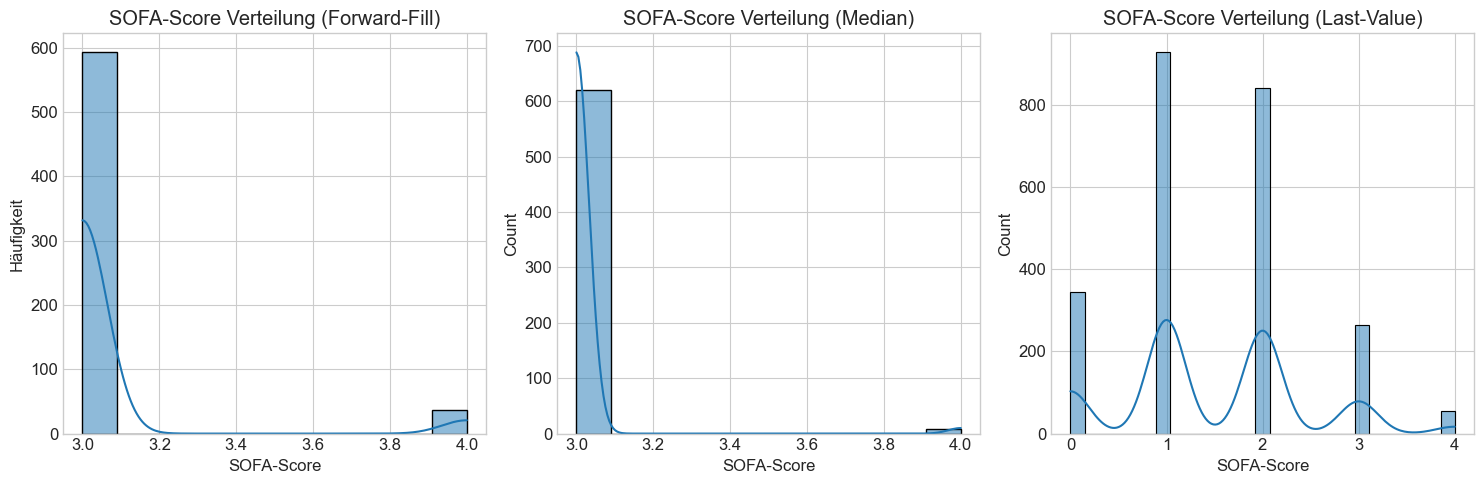

In [29]:
# Überprüfen, ob alle DataFrames die SOFA-Score-Spalte enthalten
if 'SOFA_score' in gold_data_1.columns and 'SOFA_score' in gold_data_2.columns and 'SOFA_score' in gold_data_3.columns:
    # Statistiken der SOFA-Scores
    print("Statistiken der SOFA-Scores (Methode 1 - Forward-Fill):")
    print(gold_data_1['SOFA_score'].describe())
    
    print("\nStatistiken der SOFA-Scores (Methode 2 - Median):")
    print(gold_data_2['SOFA_score'].describe())
    
    print("\nStatistiken der SOFA-Scores (Methode 3 - Last-Value):")
    print(gold_data_3['SOFA_score'].describe())
    
    # Teilscores anzeigen
    sofa_components_1 = [col for col in gold_data_1.columns if col.startswith('SOFA_') and col != 'SOFA_score']
    if sofa_components_1:
        print("\nTeilscores (Methode 1 - Forward-Fill):")
        for component in sofa_components_1:
            print(f"\n{component}:")
            print(gold_data_1[component].describe())
    
    # Histogramm der SOFA-Scores
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    sns.histplot(gold_data_1['SOFA_score'], kde=True)
    plt.title('SOFA-Score Verteilung (Forward-Fill)')
    plt.xlabel('SOFA-Score')
    plt.ylabel('Häufigkeit')
    
    plt.subplot(1, 3, 2)
    sns.histplot(gold_data_2['SOFA_score'], kde=True)
    plt.title('SOFA-Score Verteilung (Median)')
    plt.xlabel('SOFA-Score')
    
    plt.subplot(1, 3, 3)
    sns.histplot(gold_data_3['SOFA_score'], kde=True)
    plt.title('SOFA-Score Verteilung (Last-Value)')
    plt.xlabel('SOFA-Score')
    
    plt.tight_layout()
    plt.show()
else:
    print("SOFA_score-Spalte nicht in allen DataFrames vorhanden.")

## 8. Zeitlicher Verlauf der SOFA-Scores für einen Patienten

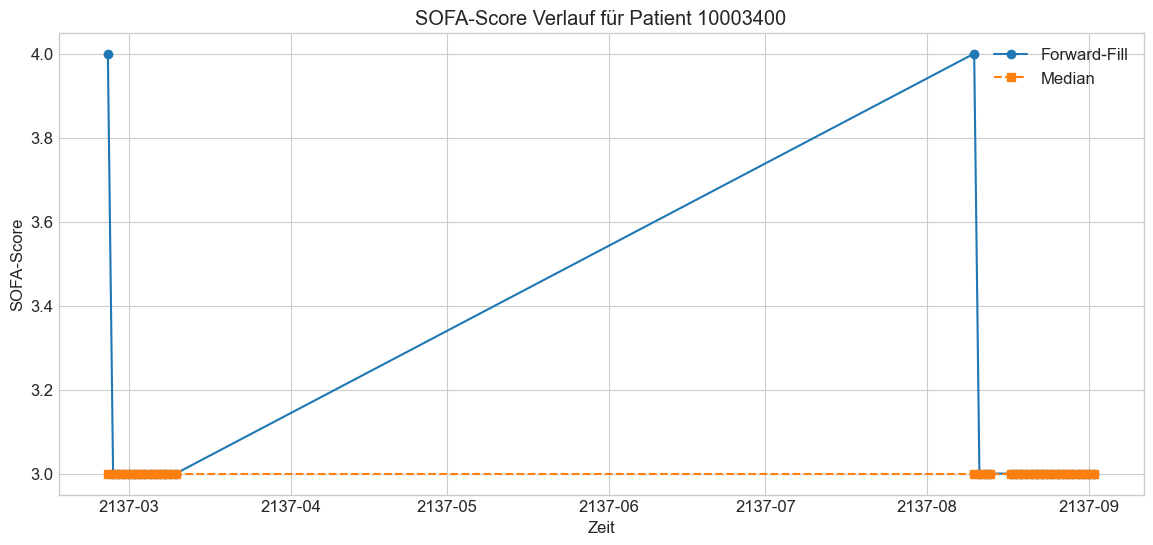

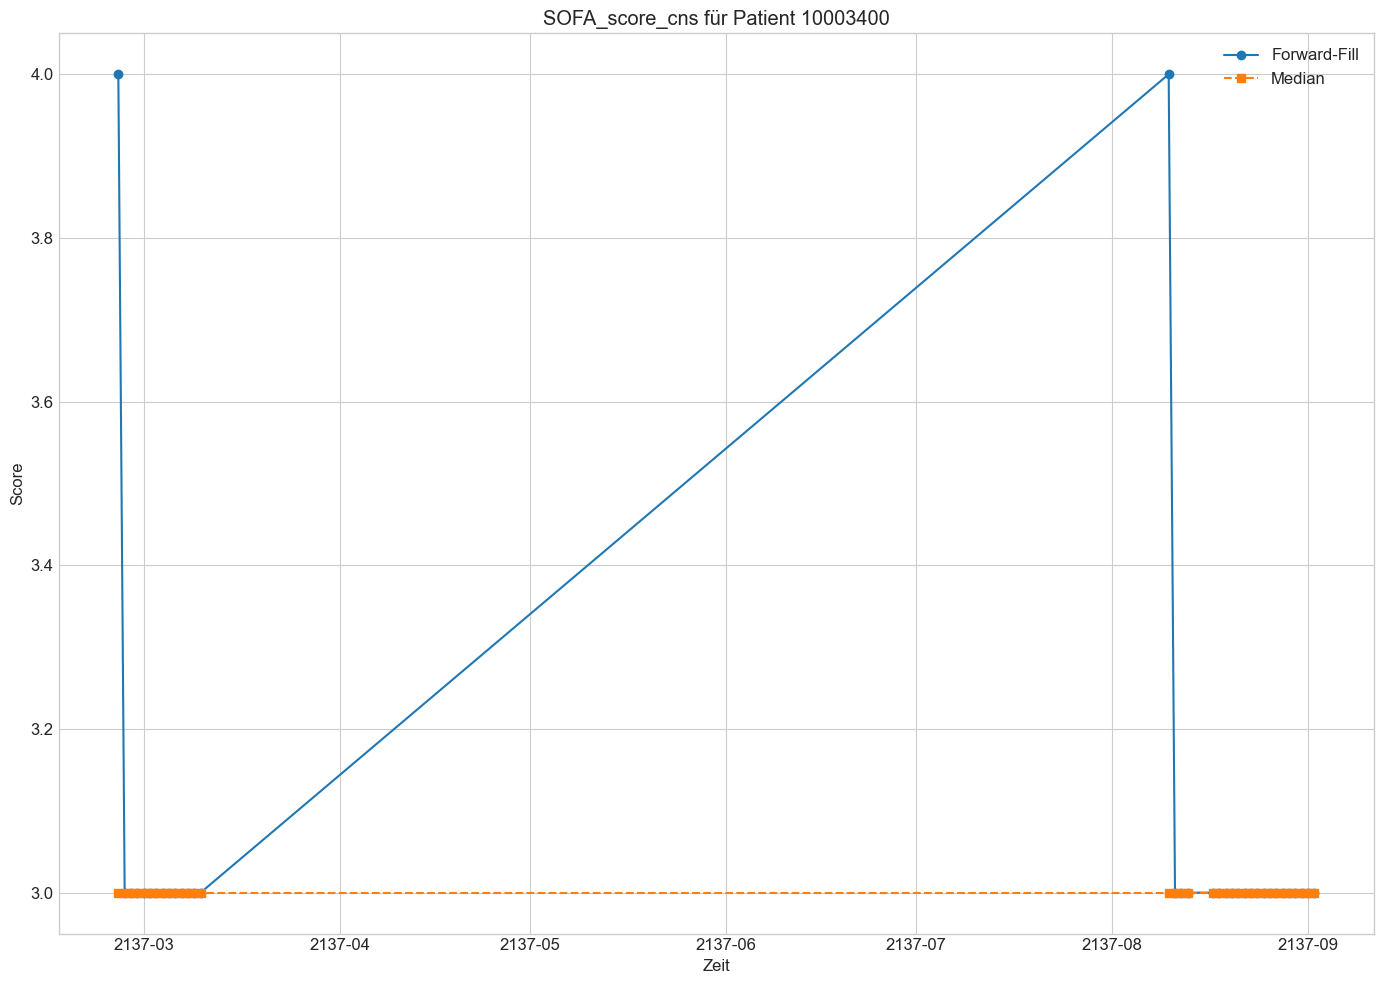

In [30]:
# Patienten mit den meisten Datenpunkten identifizieren
if 'subject_id' in gold_data_1.columns:
    patient_counts = gold_data_1['subject_id'].value_counts()
    if len(patient_counts) > 0:
        # Top-Patient mit den meisten Datenpunkten auswählen
        top_patient = patient_counts.index[0]
        
        # Daten für diesen Patienten extrahieren
        patient_data_1 = gold_data_1[gold_data_1['subject_id'] == top_patient].copy()
        patient_data_2 = gold_data_2[gold_data_2['subject_id'] == top_patient].copy()
        
        # Zeitstempelspalte identifizieren
        time_col = None
        for col in ['time_window', 'charttime', 'starttime']:
            if col in patient_data_1.columns:
                time_col = col
                break
        
        if time_col is not None:
            # Nach Zeit sortieren
            patient_data_1 = patient_data_1.sort_values(by=time_col)
            patient_data_2 = patient_data_2.sort_values(by=time_col)
            
            # Zeitreihenplot der SOFA-Scores
            plt.figure(figsize=(14, 6))
            plt.plot(patient_data_1[time_col], patient_data_1['SOFA_score'], 'o-', label='Forward-Fill')
            plt.plot(patient_data_2[time_col], patient_data_2['SOFA_score'], 's--', label='Median')
            plt.title(f'SOFA-Score Verlauf für Patient {top_patient}')
            plt.xlabel('Zeit')
            plt.ylabel('SOFA-Score')
            plt.legend()
            plt.grid(True)
            plt.show()
            
            # Komponenten des SOFA-Scores für diesen Patienten
            sofa_components = [col for col in patient_data_1.columns if col.startswith('SOFA_') and col != 'SOFA_score']
            
            if sofa_components:
                plt.figure(figsize=(14, 10))
                for i, component in enumerate(sofa_components):
                    plt.subplot(len(sofa_components), 1, i+1)
                    plt.plot(patient_data_1[time_col], patient_data_1[component], 'o-', label='Forward-Fill')
                    if component in patient_data_2.columns:
                        plt.plot(patient_data_2[time_col], patient_data_2[component], 's--', label='Median')
                    plt.title(f'{component} für Patient {top_patient}')
                    plt.ylabel('Score')
                    plt.legend()
                    plt.grid(True)
                    
                    if i == len(sofa_components) - 1:
                        plt.xlabel('Zeit')
                        
                plt.tight_layout()
                plt.show()
        else:
            print("Keine Zeitspalte in den Daten gefunden.")
    else:
        print("Keine Patienten in den Daten gefunden.")
else:
    print("Keine 'subject_id'-Spalte in den Daten gefunden.")

## 9. Erweiterte Visualisierung der klinischen Parameter

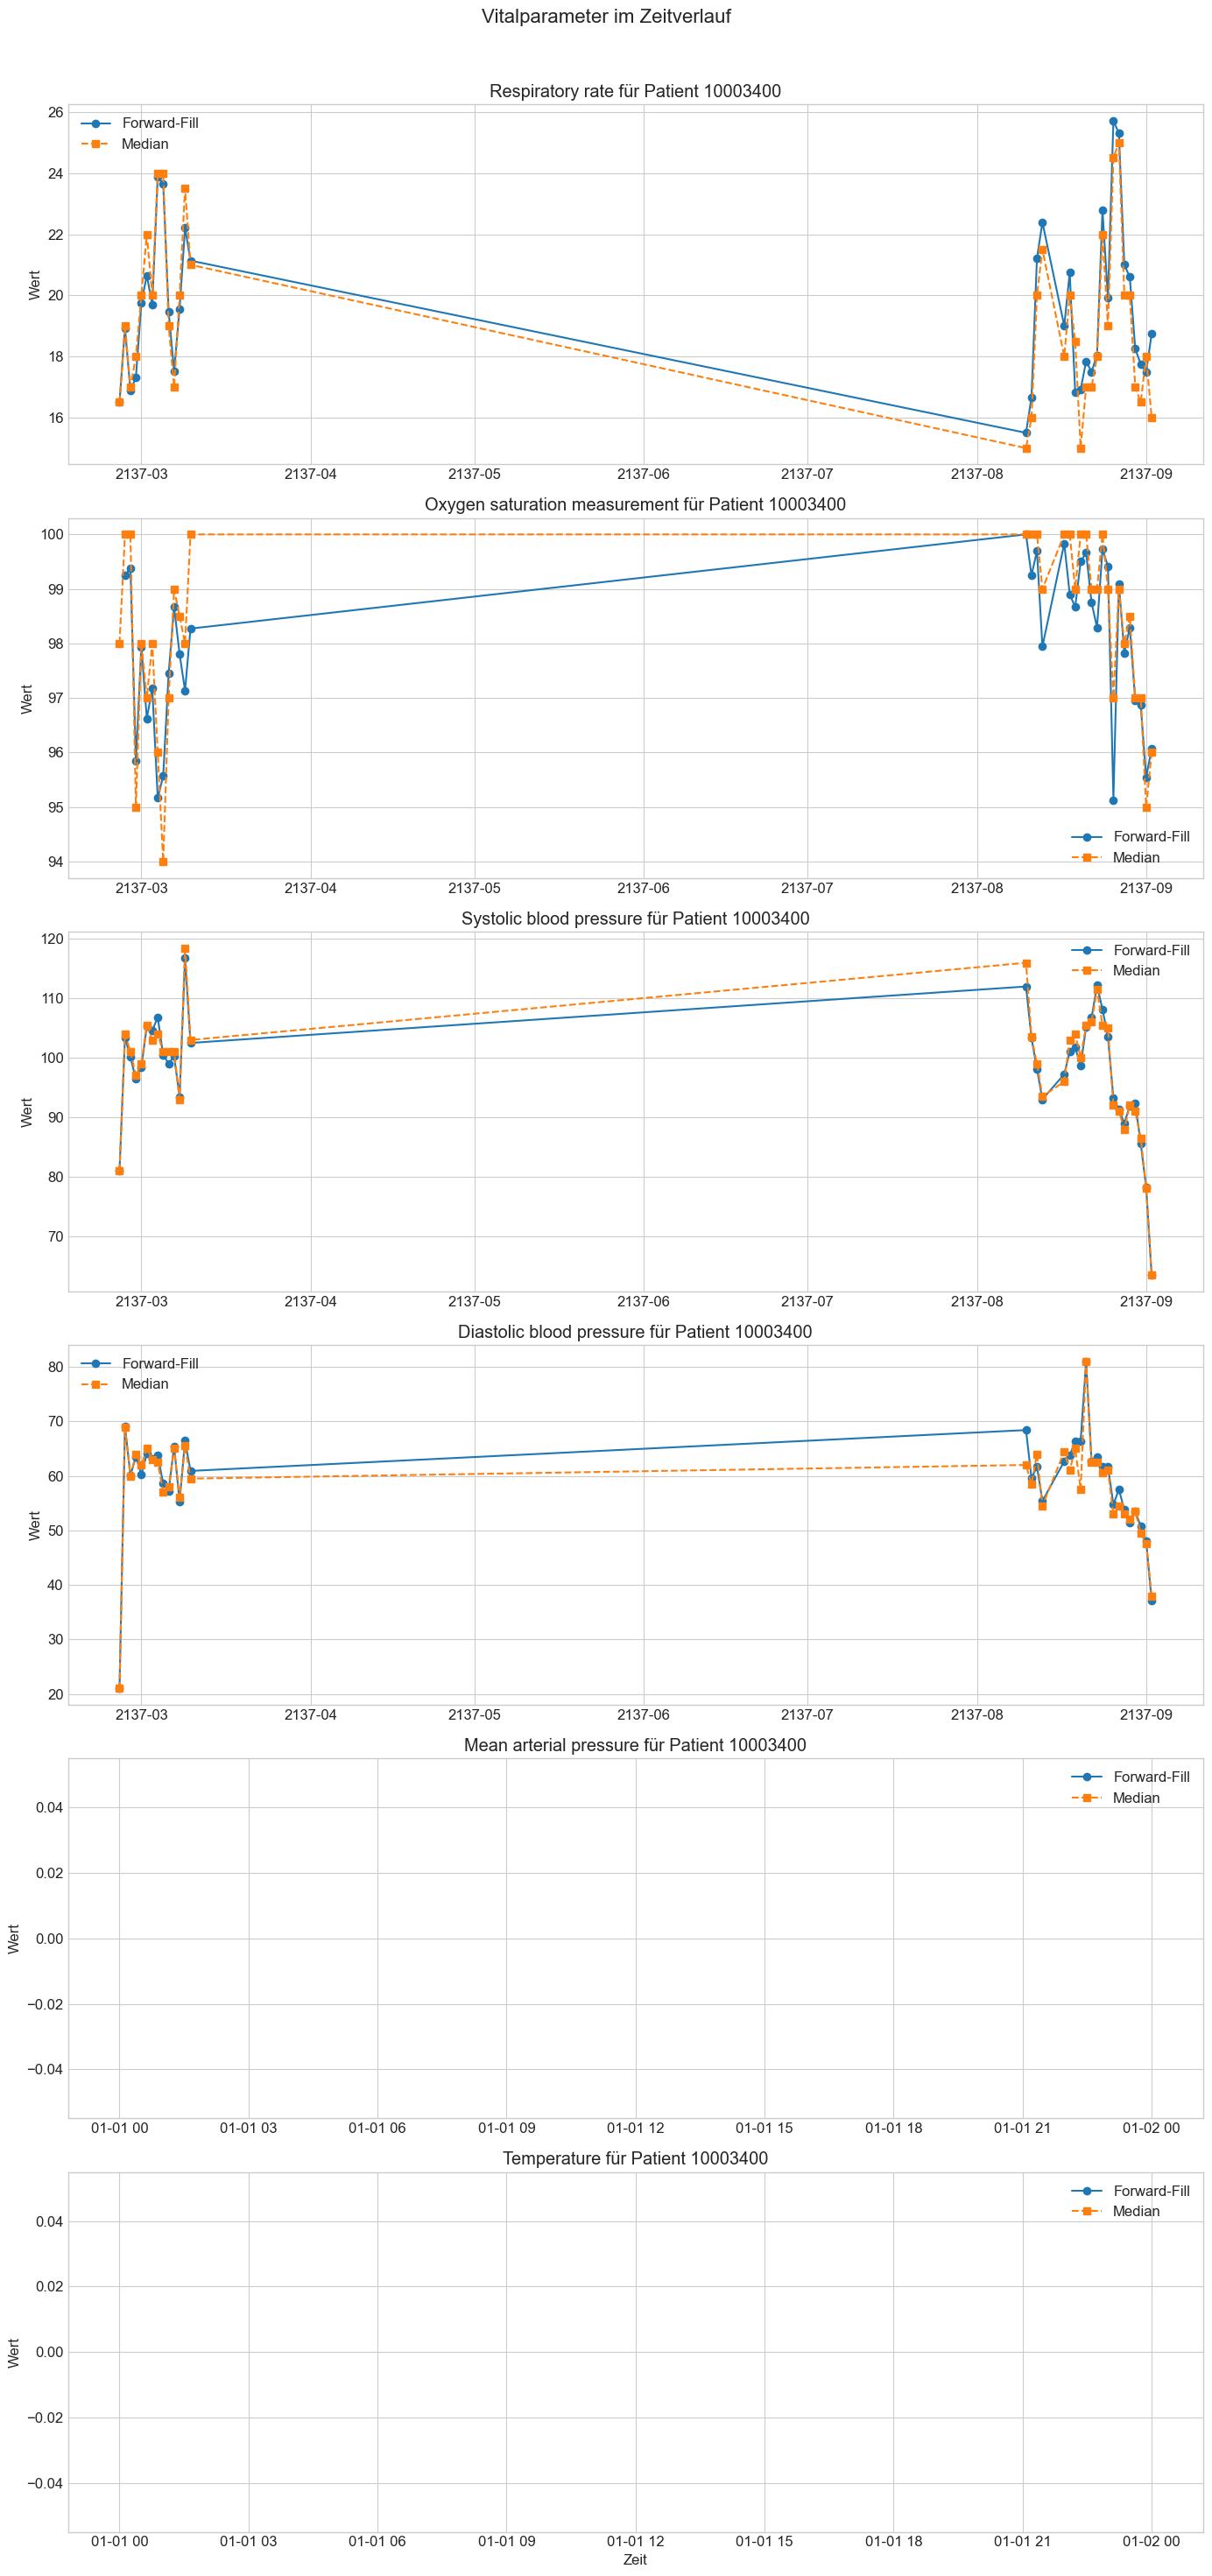

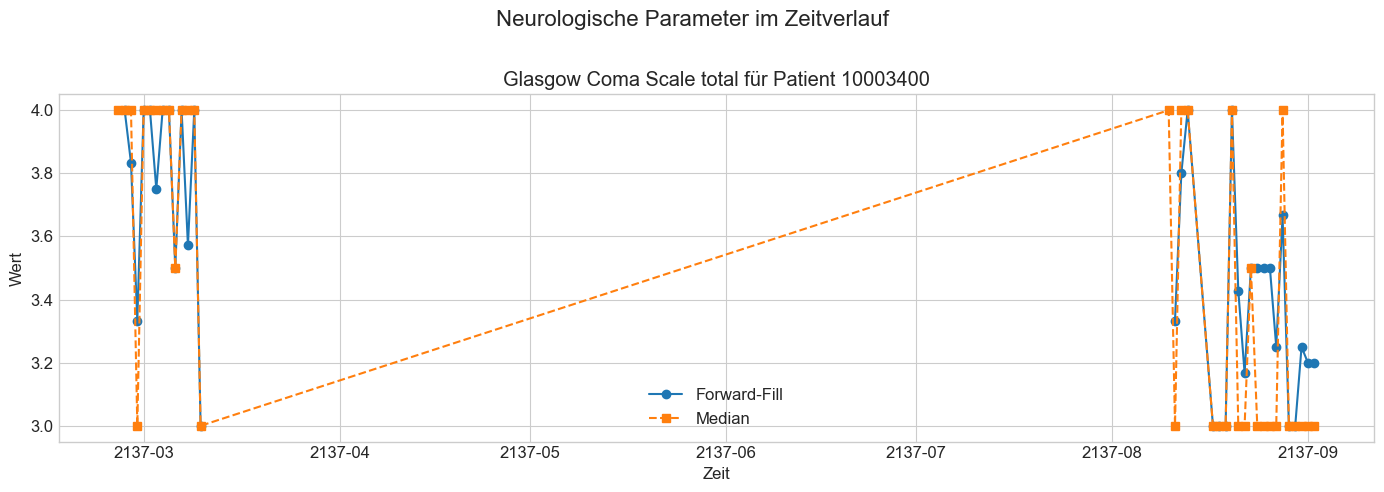

In [31]:
# Visualisierung der zusätzlichen klinischen Parameter
if 'subject_id' in gold_data_1.columns and len(patient_data_1) > 0:
    # Kategorien von Parametern für die Visualisierung
    viz_categories = {
        "Vitalparameter": ["Respiratory rate", "Oxygen saturation measurement", 
                          "Systolic blood pressure", "Diastolic blood pressure", 
                          "Mean arterial pressure", "Temperature"],
        "Neurologische Parameter": ["Glasgow Coma Scale total"],
        "Laborwerte": ["Platelets", "Bilirubin.total", "Creatinine"],
        "Beatmungsparameter": ["PaO2_FiO2_ratio"]
    }
    
    # Für jede Kategorie eine Visualisierung erstellen
    for category, params in viz_categories.items():
        # Filtern der verfügbaren Parameter
        available_params = [p for p in params if p in patient_data_1.columns]
        
        if available_params:
            plt.figure(figsize=(14, 5 * len(available_params)))
            for i, param in enumerate(available_params):
                plt.subplot(len(available_params), 1, i+1)
                plt.plot(patient_data_1['time_window'], patient_data_1[param], 'o-', label='Forward-Fill')
                if param in patient_data_2.columns:
                    plt.plot(patient_data_2['time_window'], patient_data_2[param], 's--', label='Median')
                plt.title(f'{param} für Patient {top_patient}')
                plt.ylabel('Wert')
                plt.legend()
                plt.grid(True)
                
                if i == len(available_params) - 1:
                    plt.xlabel('Zeit')
            
            plt.suptitle(f'{category} im Zeitverlauf', fontsize=16)
            plt.tight_layout(rect=[0, 0, 1, 0.97])
            plt.show()
else:
    print("Keine Patientendaten für die erweiterte Visualisierung verfügbar.")

## 10. Speichern der Ergebnisse

In [ ]:
# Speichern der Ergebnisse in der Datenbank
save_to_db = False  # Auf True setzen, um in die Datenbank zu speichern

if save_to_db:
    # Methode 1 (Forward-Fill)
    pipeline_1._save_to_database(gold_data_1, table='sofa_24h_forwardfill')
    print("Methode 1 (Forward-Fill) in der Datenbank gespeichert.")
    
    # Methode 2 (Median)
    pipeline_2._save_to_database(gold_data_2, table='sofa_alternative')
    print("Methode 2 (Median) in der Datenbank gespeichert.")
    
    # Methode 3 (Last-Value)
    pipeline_3._save_to_database(gold_data_3, table='sofa_last_value')
    print("Methode 3 (Last-Value) in der Datenbank gespeichert.")
else:
    print("Ergebnisse wurden nicht in der Datenbank gespeichert.")

# Speichern als CSV-Dateien
os.makedirs('../data/gold', exist_ok=True)
gold_data_1.to_csv('../data/gold/sofa_24h_forwardfill.csv', index=False)
gold_data_2.to_csv('../data/gold/sofa_alternative.csv', index=False)
gold_data_3.to_csv('../data/gold/sofa_last_value.csv', index=False)
print("Ergebnisse als CSV-Dateien gespeichert.")

## 11. Zusammenfassung

### Vergleich der Imputationsmethoden

In diesem Notebook haben wir drei verschiedene Methoden zur Berechnung des SOFA-Scores verglichen:

1. **Forward-Fill-Imputation**: Fehlende Werte werden mit dem letzten bekannten Wert aufgefüllt. Dies ist klinisch oft sinnvoll, da sich Patientenzustände typischerweise nicht abrupt ändern.

2. **Median-Imputation**: Fehlende Werte werden mit dem Median der vorhandenen Werte aufgefüllt. Dies kann robuster gegen Ausreißer sein, berücksichtigt aber nicht den zeitlichen Verlauf.

3. **Last-Value-Imputation**: Fehlende Werte werden mit dem letzten verfügbaren Messwert aufgefüllt, wobei nur Werte berücksichtigt werden, die zeitlich vor dem fehlenden Wert liegen. Dies ist klinisch besonders relevant, da es die tatsächliche Entscheidungssituation widerspiegelt, in der nur vergangene Messungen bekannt sind.

### Klinische Relevanz

Die Wahl der Imputationsmethode kann erhebliche Auswirkungen auf die berechneten SOFA-Scores haben, was wiederum klinische Entscheidungen beeinflussen kann. Insbesondere:

- Forward-Fill kann zu einer Überschätzung der Organdysfunktion führen, wenn sich der Zustand des Patienten verbessert, aber keine neuen Messungen vorliegen.
- Median-Imputation kann zu einer Unterschätzung der Organdysfunktion führen, wenn sich der Zustand des Patienten verschlechtert, aber keine neuen Messungen vorliegen.
- Last-Value-Imputation berücksichtigt nur die zeitliche Reihenfolge der Messungen und spiegelt am besten die klinische Realität wider, da nur vergangene Messungen für die Entscheidungsfindung zur Verfügung stehen.

### Medaillon-Prinzip

Dieses Beispiel zeigt das Medaillon-Prinzip in Aktion:

1. **Bronze**: Extraktion der Rohdaten aus MIMIC-IV
2. **Silber**: Standardisierung und Qualitätssicherung der Daten
3. **Gold**: Berechnung des SOFA-Scores mit verschiedenen Methoden

Durch diese strukturierte Herangehensweise können wir die Datenqualität in jeder Stufe sicherstellen und verschiedene Analysemethoden transparent vergleichen.